# GatedGCNs with DGL

From [Bresson & Laurent (2018) Residual Gated Graph ConvNets](https://arxiv.org/abs/1711.07553), adapted from [Xavier's notebook](https://drive.google.com/file/d/1WG5t6X12Z70JPtvA2-2PzdK3TMTQMsvm).

In [1]:
# Import libs
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import os
os.environ['DGLBACKEND'] = 'pytorch'  # tell DGL what backend to use
import dgl
from dgl import DGLGraph
from dgl.data import MiniGCDataset

import time

import numpy as np
import networkx as nx
from res.plot_lib import set_default
import matplotlib.pyplot as plt

Using backend: pytorch


In [4]:
set_default(figsize=(3, 3), dpi=150)
def draw(g, title):
    plt.figure()
    nx.draw(g.to_networkx(), with_labels=True, node_color='skyblue', edge_color='white')
    plt.gcf().set_facecolor('k')
    plt.title(title)

## Mini graph classification dataset

```python
class dgl.data.MiniGCDataset(num_graphs, min_num_v, max_num_v)
```

 - `num_graphs`: number of graphs in this dataset
 - `min_num_v`: minimum number of nodes for graphs
 - `max_num_v`: maximum number of nodes for graphs

In [5]:
# The datset contains 8 different types of graphs:
graph_type = (
    'cycle',
    'star',
    'wheel',
    'lollipop',
    'hypercube',
    'grid',
    'clique',
    'circular ladder',
)

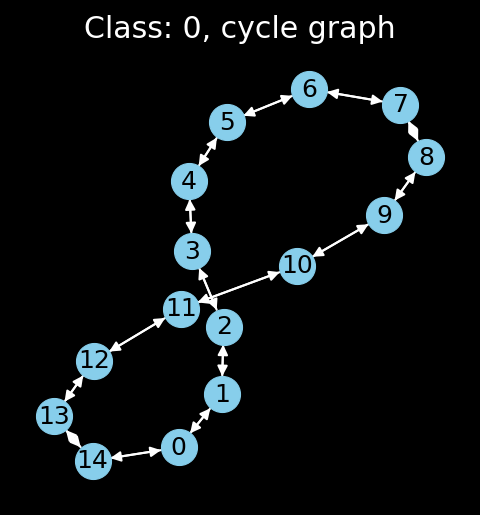

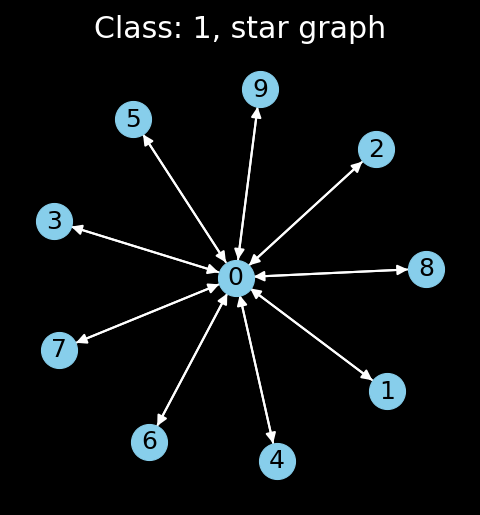

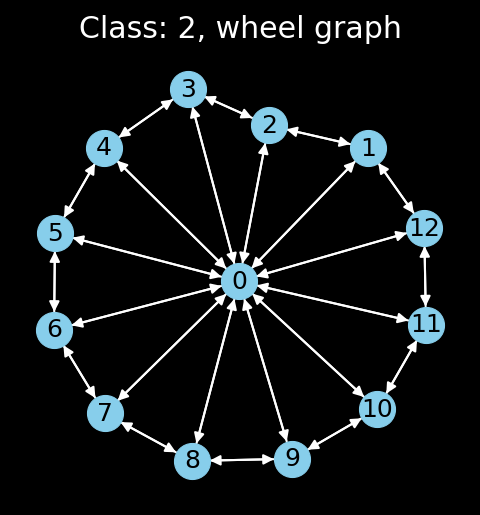

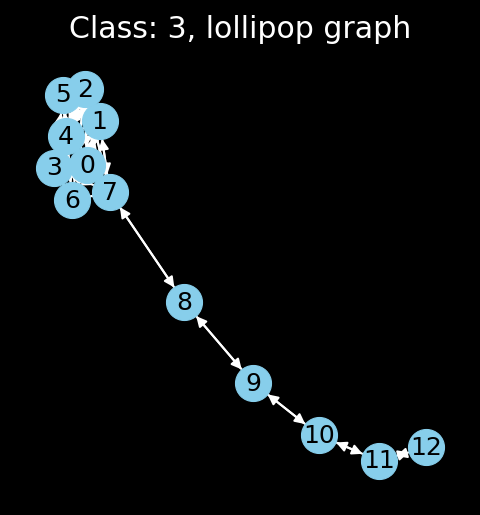

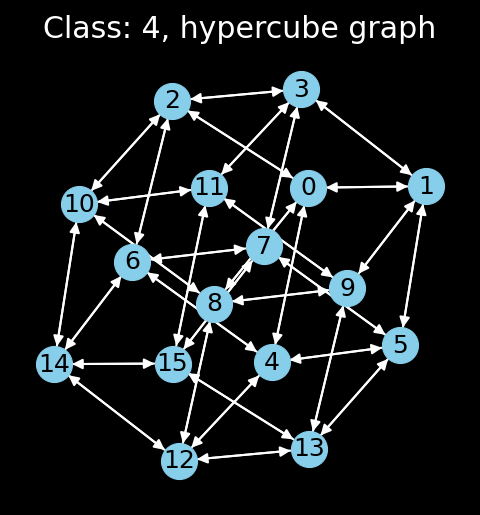

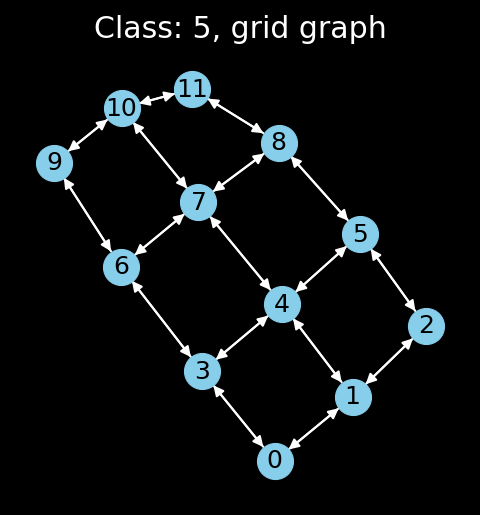

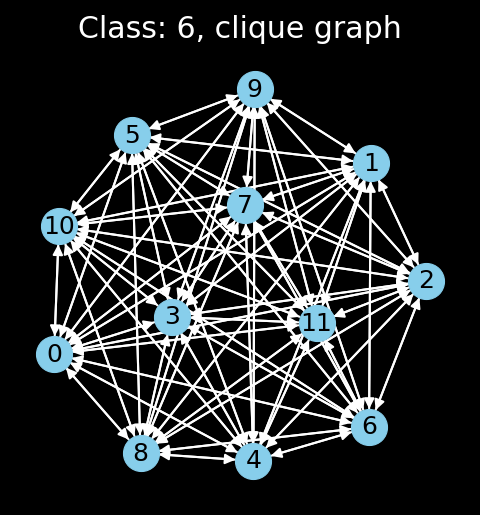

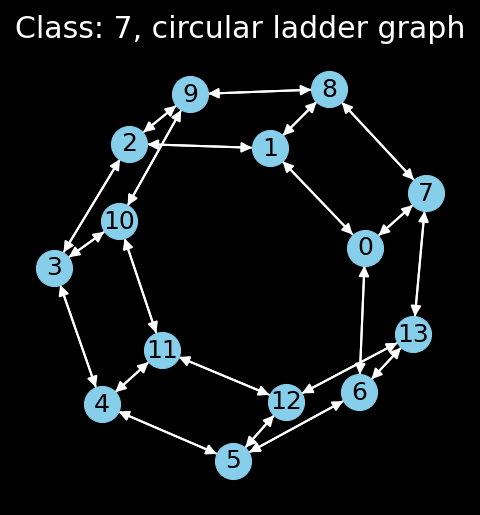

In [6]:
# visualise the 8 classes of graphs
for graph, label in MiniGCDataset(8, 10, 20):
    draw(graph, f'Class: {label}, {graph_type[label]} graph')

## Let's add some signal to the domain

We can assign features to nodes and edges of a `DGLGraph`. The features are represented as dictionary of names (strings) and tensors, called **fields**. `ndata` and `edata` are syntax sugar to access the feature data of all nodes and edges.

In [5]:
# create artifical data feature (= in degree) for each node
def create_artificial_features(dataset):
    for (graph, _) in dataset:
        graph.ndata['feat'] = graph.in_degrees().view(-1, 1).float()
        graph.edata['feat'] = torch.ones(graph.number_of_edges(), 1)
    return dataset

In [6]:
# Generate artifical graph dataset with DGL
trainset = MiniGCDataset(350, 10, 20)
testset = MiniGCDataset(100, 10, 20)

trainset = create_artificial_features(trainset)
testset = create_artificial_features(testset)

print(trainset[0])

(DGLGraph(num_nodes=13, num_edges=39,
         ndata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}), 0)


## GatedGCNs equations

$$
\def \vx {\boldsymbol{\color{Plum}{x}}}
\def \vh {\boldsymbol{\color{YellowGreen}{h}}}
\def \ve {\boldsymbol{\color{purple}{e}}}
\def \aqua#1{\color{Aquamarine}{#1}}
\def \red#1{\color{OrangeRed}{#1}}
$$

\begin{aligned}
\vh &= \vx + \Big( A \vx +  \sum_{\aqua{v}_j \to \red{v}} \eta(\ve_{j}) \odot B \vx_j \Big)^+\\
\eta(\ve_{j}) &= \sigma(\ve_{j})\Big(\sum_{\aqua{v}_k \to \red{v}} \sigma(\ve_{k})\Big)^{-1} \\
\ve_{j} &= C \ve_{j}^{\vx} + D \vx_j + E\vx\\
\ve_{j}^{\vh} &= \ve_j^{\vx} + \Big( \ve_{j}  \Big)^+
\end{aligned}

In DGL, the *message functions* are expressed as **Edge UDF**s (User Defined Functions). Edge UDFs take in a single argument `edges`. It has three members `src`, `dst`, and `data` for accessing source node features, destination node features, and edge features.

The *reduce functions* are **Node UDF**s. Node UDFs have a single argument `nodes`, which has two members `data` and `mailbox`. `data` contains the node features and `mailbox` contains all incoming message features, stacked along the second dimension (hence the `dim=1` argument).

`update_all(message_func, reduce_func)` send messages through all edges and update all nodes.
Optionally, apply a function to update the node features after receive.
This is a convenient combination for performing `send(g.edges(), message_func)` and `recv(g.nodes(), reduce_func)`.

In [7]:
class GatedGCN_layer(nn.Module):
    
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.A = nn.Linear(input_dim, output_dim)
        self.B = nn.Linear(input_dim, output_dim)
        self.C = nn.Linear(input_dim, output_dim)
        self.D = nn.Linear(input_dim, output_dim)
        self.E = nn.Linear(input_dim, output_dim)
        self.bn_node_h = nn.BatchNorm1d(output_dim)
        self.bn_node_e = nn.BatchNorm1d(output_dim)

    def message_func(self, edges):
        Bx_j = edges.src['BX']
        # e_j = Ce_j + Dxj + Ex
        e_j = edges.data['CE'] + edges.src['DX'] + edges.dst['EX']
        edges.data['E'] = e_j
        return {'Bx_j' : Bx_j, 'e_j' : e_j}

    def reduce_func(self, nodes):
        Ax = nodes.data['AX']
        Bx_j = nodes.mailbox['Bx_j']
        e_j = nodes.mailbox['e_j']
        # sigma_j = σ(e_j)
        σ_j = torch.sigmoid(e_j)
        # h = Ax + Σ_j η_j * Bxj
        h = Ax + torch.sum(σ_j * Bx_j, dim=1) / torch.sum(σ_j, dim=1)
        return {'H' : h}
    
    def forward(self, g, X, E_X, snorm_n, snorm_e):
        
        g.ndata['H']  = X
        g.ndata['AX'] = self.A(X) 
        g.ndata['BX'] = self.B(X) 
        g.ndata['DX'] = self.D(X)
        g.ndata['EX'] = self.E(X) 
        g.edata['E']  = E_X
        g.edata['CE'] = self.C(E_X)
        
        g.update_all(self.message_func, self.reduce_func)
        
        H = g.ndata['H'] # result of graph convolution
        E = g.edata['E'] # result of graph convolution
        
        H *= snorm_n # normalize activation w.r.t. graph node size
        E *= snorm_e # normalize activation w.r.t. graph edge size
        
        H = self.bn_node_h(H) # batch normalization  
        E = self.bn_node_e(E) # batch normalization  
        
        H = torch.relu(H) # non-linear activation
        E = torch.relu(E) # non-linear activation
        
        H = X + H # residual connection
        E = E_X + E # residual connection
        
        return H, E

In [8]:
class MLP_layer(nn.Module):
    
    def __init__(self, input_dim, output_dim, L=2): # L = nb of hidden layers
        super().__init__()
        list_FC_layers = [
            nn.Linear(input_dim, input_dim) for l in range(L)
        ]
        list_FC_layers.append(nn.Linear(input_dim, output_dim))
        self.FC_layers = nn.ModuleList(list_FC_layers)
        self.L = L
        
    def forward(self, x):
        y = x
        for l in range(self.L):
            y = self.FC_layers[l](y)
            y = torch.relu(y)
        y = self.FC_layers[self.L](y)
        return y

In [9]:
class GatedGCN(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, L):
        super().__init__()
        self.embedding_h = nn.Linear(input_dim, hidden_dim)
        self.embedding_e = nn.Linear(1, hidden_dim)
        self.GatedGCN_layers = nn.ModuleList([
            GatedGCN_layer(hidden_dim, hidden_dim) for _ in range(L)
        ])
        self.MLP_layer = MLP_layer(hidden_dim, output_dim)
        
    def forward(self, g, X, E, snorm_n, snorm_e):
        
        # input embedding
        H = self.embedding_h(X)
        E = self.embedding_e(E)
        
        # graph convnet layers
        for GGCN_layer in self.GatedGCN_layers:
            H, E = GGCN_layer(g, H, E, snorm_n, snorm_e)
        
        # MLP classifier
        g.ndata['H'] = H
        y = dgl.mean_nodes(g, 'H')
        y = self.MLP_layer(y)
        
        return y

In [10]:
# instantiate network
model = GatedGCN(input_dim=1, hidden_dim=100, output_dim=8, L=2)
print(model)

GatedGCN(
  (embedding_h): Linear(in_features=1, out_features=100, bias=True)
  (embedding_e): Linear(in_features=1, out_features=100, bias=True)
  (GatedGCN_layers): ModuleList(
    (0): GatedGCN_layer(
      (A): Linear(in_features=100, out_features=100, bias=True)
      (B): Linear(in_features=100, out_features=100, bias=True)
      (C): Linear(in_features=100, out_features=100, bias=True)
      (D): Linear(in_features=100, out_features=100, bias=True)
      (E): Linear(in_features=100, out_features=100, bias=True)
      (bn_node_h): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn_node_e): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): GatedGCN_layer(
      (A): Linear(in_features=100, out_features=100, bias=True)
      (B): Linear(in_features=100, out_features=100, bias=True)
      (C): Linear(in_features=100, out_features=100, bias=True)
      (D): Linear(in_features=100, out_features=100, 

## Define a few helper functions

In [11]:
# Collate function to prepare graphs

def collate(samples):
    graphs, labels = map(list, zip(*samples))  # samples is a list of pairs (graph, label)
    labels = torch.tensor(labels)
    sizes_n = [graph.number_of_nodes() for graph in graphs] # graph sizes
    snorm_n = [torch.FloatTensor(size, 1).fill_(1 / size) for size in sizes_n]
    snorm_n = torch.cat(snorm_n).sqrt()  # graph size normalization 
    sizes_e = [graph.number_of_edges() for graph in graphs] # nb of edges
    snorm_e = [torch.FloatTensor(size, 1).fill_(1 / size) for size in sizes_e]
    snorm_e = torch.cat(snorm_e).sqrt()  # graph size normalization
    batched_graph = dgl.batch(graphs)  # batch graphs
    return batched_graph, labels, snorm_n, snorm_e

In [12]:
# Compute accuracy

def accuracy(logits, targets):
    preds = logits.detach().argmax(dim=1)
    acc = (preds==targets).sum().item()
    return acc

## Test forward pass

In [13]:
# Define DataLoader and get first graph batch

train_loader = DataLoader(trainset, batch_size=10, shuffle=True, collate_fn=collate)
batch_graphs, batch_labels, batch_snorm_n, batch_snorm_e = next(iter(train_loader))
batch_X = batch_graphs.ndata['feat']
batch_E = batch_graphs.edata['feat']

In [14]:
# Checking some sizes

print(f'batch_graphs:', batch_graphs)
print(f'batch_labels:', batch_labels)
print('batch_X size:', batch_X.size())
print('batch_E size:', batch_E.size())

batch_graphs: DGLGraph(num_nodes=138, num_edges=924,
         ndata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)})
batch_labels: tensor([6, 4, 0, 3, 0, 0, 2, 7, 5, 6])
batch_x size: torch.Size([138, 1])
batch_e size: torch.Size([924, 1])


In [15]:
batch_scores = model(batch_graphs, batch_x, batch_e, batch_snorm_n, batch_snorm_e)
print(batch_scores.size())

batch_labels = batch_labels
print(f'accuracy: {accuracy(batch_scores, batch_labels)}')

torch.Size([10, 8])
accuracy: 2


## Test backward pass

In [16]:
# Loss
J = nn.CrossEntropyLoss()(batch_scores, batch_labels)

# Backward pass
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
optimizer.zero_grad()
J.backward()
optimizer.step()

## Train one epoch

In [17]:
def train(model, data_loader, loss):

    model.train()
    epoch_loss = 0
    epoch_train_acc = 0
    nb_data = 0
    gpu_mem = 0

    for iter, (batch_graphs, batch_labels, batch_snorm_n, batch_snorm_e) in enumerate(data_loader):
        batch_X = batch_graphs.ndata['feat']
        batch_E = batch_graphs.edata['feat']
        
        batch_scores = model(batch_graphs, batch_X, batch_E, batch_snorm_n, batch_snorm_e)
        J = loss(batch_scores, batch_labels)
        optimizer.zero_grad()
        J.backward()
        optimizer.step()
        
        epoch_loss += J.detach().item()
        epoch_train_acc += accuracy(batch_scores, batch_labels)
        nb_data += batch_labels.size(0)

    epoch_loss /= (iter + 1)
    epoch_train_acc /= nb_data

    return epoch_loss, epoch_train_acc

## Evaluation

In [18]:
def evaluate(model, data_loader, loss):

    model.eval()
    epoch_test_loss = 0
    epoch_test_acc = 0
    nb_data = 0
    
    with torch.no_grad():
        for iter, (batch_graphs, batch_labels, batch_snorm_n, batch_snorm_e) in enumerate(data_loader):
            batch_X = batch_graphs.ndata['feat']
            batch_E = batch_graphs.edata['feat']

            batch_scores = model(batch_graphs, batch_X, batch_E, batch_snorm_n, batch_snorm_e)
            J = loss(batch_scores, batch_labels)

            epoch_test_loss += J.detach().item()
            epoch_test_acc += accuracy(batch_scores, batch_labels)
            nb_data += batch_labels.size(0)

        epoch_test_loss /= (iter + 1)
        epoch_test_acc /= nb_data
    
    return epoch_test_loss, epoch_test_acc

# Train GNN

In [19]:
# datasets
train_loader = DataLoader(trainset, batch_size=50, shuffle=True, collate_fn=collate)
test_loader = DataLoader(testset, batch_size=50, shuffle=False, collate_fn=collate)

# Create model
model = GatedGCN(input_dim=1, hidden_dim=100, output_dim=8, L=4)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

epoch_train_losses = []
epoch_test_losses = []
epoch_train_accs = []
epoch_test_accs = []

for epoch in range(40):
    
    start = time.time()
    train_loss, train_acc = train(model, train_loader, loss)
    test_loss, test_acc = evaluate(model, test_loader, loss)
        
    print(f'Epoch {epoch}, train_loss: {train_loss:.4f}, test_loss: {test_loss:.4f}')
    print(f'train_acc: {train_acc:.4f}, test_acc: {test_acc:.4f}')

Epoch 0, train_loss: 1.9461, test_loss: 2.0031
train_acc: 0.2171, test_acc: 0.1200
Epoch 1, train_loss: 1.8246, test_loss: 1.9327
train_acc: 0.3543, test_acc: 0.1200
Epoch 2, train_loss: 1.7516, test_loss: 1.8489
train_acc: 0.3714, test_acc: 0.2400
Epoch 3, train_loss: 1.6833, test_loss: 1.7646
train_acc: 0.3743, test_acc: 0.3500
Epoch 4, train_loss: 1.6202, test_loss: 1.6799
train_acc: 0.4086, test_acc: 0.3700
Epoch 5, train_loss: 1.5641, test_loss: 1.5983
train_acc: 0.4457, test_acc: 0.4300
Epoch 6, train_loss: 1.4973, test_loss: 1.5193
train_acc: 0.5200, test_acc: 0.4700
Epoch 7, train_loss: 1.4708, test_loss: 1.4512
train_acc: 0.5400, test_acc: 0.6200
Epoch 8, train_loss: 1.3893, test_loss: 1.3852
train_acc: 0.6086, test_acc: 0.6100
Epoch 9, train_loss: 1.3398, test_loss: 1.3250
train_acc: 0.6229, test_acc: 0.6900
Epoch 10, train_loss: 1.2827, test_loss: 1.2678
train_acc: 0.6943, test_acc: 0.8600
Epoch 11, train_loss: 1.2282, test_loss: 1.2100
train_acc: 0.6943, test_acc: 0.8300
Ep